## 驾驶员状态检测
在这个项目中，需要通过驾驶员状态的图片推测出驾驶员处于什么样的状态，在运行该 notebook 之前，需要按照数据处理的指示将数据预处理好，如果你已经完成了前面的过程，我们正式进入到项目中。

In [1]:
%reload_ext autoreload
%autoreload 2

# 导入所有的包
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

from torchvision import transforms as tfs

首先我们可视化几张图片，来看看具体图片是什么样的

In [2]:
from PIL import Image
img1 = Image.open('./dataset/train/c0/img_12247.jpg')
img2 = Image.open('./dataset/train/c1/img_100021.jpg')
img3 = Image.open('./dataset/train/c2/img_100108.jpg')
img4 = Image.open('./dataset/train/c3/img_100006.jpg')

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

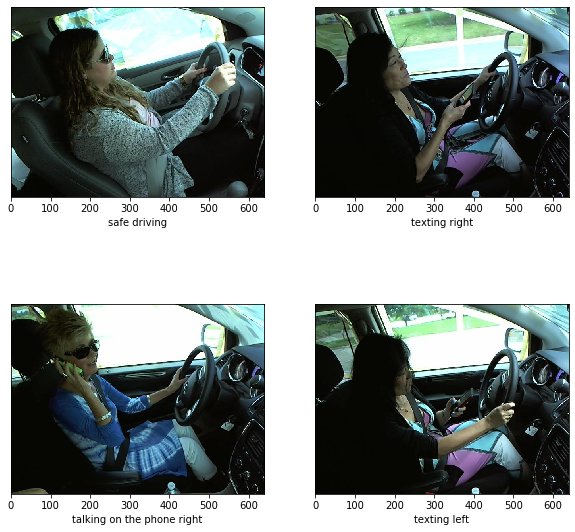

In [4]:
nrows = 2
ncols = 2
figsize = (10, 10)
_, figs = plt.subplots(nrows, ncols, figsize=figsize)
figs[0, 0].imshow(img1)
figs[0, 0].axes.set_xlabel('safe driving')
figs[0, 0].axes.get_yaxis().set_visible(False)
figs[0, 1].imshow(img2)
figs[0, 1].axes.set_xlabel('texting right')
figs[0, 1].axes.get_yaxis().set_visible(False)
figs[1, 0].imshow(img3)
figs[1, 0].axes.set_xlabel('talking on the phone right')
figs[1, 0].axes.get_yaxis().set_visible(False)
figs[1, 1].imshow(img4)
figs[1, 1].axes.set_xlabel('texting left')
figs[1, 1].axes.get_yaxis().set_visible(False)

上面从左往右，从上到下依次是：安全驾驶，右手发信息，右手打电话，左手发信息的图片，通过图片展示，相信你已经更好的理解了该项目。

### 数据预处理
在数据传入图片中，我们需要进行数据预处理和数据增强的操作，相信在前面的课程中你已经了解到了这些内容，下面需要你实现一个数据的预处理

常见的数据预处理：
 - resize
 - crop
 - normalize
 - ...

等等

In [5]:
# 实现数据预处理

train_transform = tfs.Compose([
    # 训练集的数据预处理
    # todo
    tfs.Resize(400),
    tfs.RandomHorizontalFlip(),
    tfs.RandomCrop(360),
    tfs.ToTensor(),
    tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    # tfs.ColorJitter(hue = 0)
])

test_transform = tfs.Compose([
    # 测试集的数据预处理
    # todo
    tfs.Resize(400),
    tfs.CenterCrop(360),
    tfs.ToTensor(),
    tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [6]:
# 每一个batch的数据集数目，可以自行修改，推荐使用2的次方
batch_size = 8

In [7]:
# =======不要修改这里的内容========
train_set = ImageFolder('./dataset/train', train_transform)
train_data = DataLoader(train_set, batch_size, shuffle=True, num_workers=2)

valid_set = ImageFolder('./dataset/valid', test_transform)
valid_data = DataLoader(valid_set, 2 * batch_size, shuffle=False, num_workers=2)

train_valid_set = ImageFolder('./dataset/train_valid/', train_transform)
train_valid_data = DataLoader(train_valid_set, batch_size, shuffle=True, num_workers=2)


In [8]:
# 测试
# =======不要修改这里的内容========
try:
    if iter(train_data).next()[0].shape[0] == batch_size and \
    iter(valid_data).next()[0].shape[0] == 2*batch_size:
        print('Success!')
    else:
        print('Not success, maybe the batch size is wrong!')
except:
    print('not success, image transform is wrong!')

Success!


In [9]:
from torchvision import models
from torch import nn

In [10]:
# 构建模型，推荐使用 torchvision.models 中的预训练模型，将最后的全连接层修改成10分类
# 如果忘记了如何修改最后的全连接层，可以看看通过微调进行迁移学习的那个教程

def get_model():
    # todo
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(2048, 10)
    return model

构建好了模型之后，运行下面的代码对模型进行测试，看看模型是否构建正确

In [11]:
# 测试
# =======不要修改这里的内容========
try:
    model = get_model()
    score = model(Variable(iter(train_data).next()[0], volatile=True))
    if score.shape[0] == batch_size and score.shape[1] == 10:
        print('successed!')
    else:
        print('failed!')
except:
    print('model is wrong!')

/home/zzwang/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """


successed!


In [12]:
# 根据自己的情况修改是否使用GPU
use_gpu = True

In [13]:
# =======不要修改这里的内容========
if use_gpu:
    model = model.cuda()

In [14]:
# 构建loss函数和优化器

# todo
criterion = nn.CrossEntropyLoss() # 使用交叉熵作为loss函数
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-4)# 可以使用前面讲过的多种优化方式

当你构建好了前面的过程，我们就可以开始训练了，整个训练的框架已经写好，你只需要在需要的地方补充完整的代码

In [15]:
# 训练的 epochs 数目
max_epoch = 30

下面是训练的代码，只需要填写其中的 **todo** 代码

**注意: 如果你发现显存超过限制，可以改小 batch size**

In [16]:
def train(model, train_data, valid_data, max_epoch, criterion, optimizer):
    # 开始训练
    freq_print = int(len(train_data) / 3)

    metric_log = dict()
    metric_log['train_loss'] = list()
    metric_log['train_acc'] = list()
    if valid_data is not None:
        metric_log['valid_loss'] = list()
        metric_log['valid_acc'] = list()

    for e in range(max_epoch):
        model.train()
        running_loss = 0
        running_acc = 0

        for i, data in enumerate(train_data, 1):
            img, label = data
            if use_gpu:
                img = img.cuda()
                label = label.cuda()
            img = Variable(img)
            label = Variable(label)

            # 网络前向传播
            # todo
            out = model(img)

            # 计算误差
            # todo
            #print(label.shape)
            # print(out[0])
            loss = criterion(out, label)

            # 反向传播，更新参数
            # todo
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 计算准确率，是一个 Variable
            # todo
            _, pred = out.max(1)
            num_correct = (pred == label).sum()
            acc = num_correct / img.shape[0]

            running_loss += loss.item()
            running_acc += acc.item()

            if i % freq_print == 0:
                print('[{}]/[{}], train loss: {:.3f}, train acc: {:.3f}'.format(
                    i, len(train_data), running_loss / i, running_acc / i))

        metric_log['train_loss'].append(running_loss / len(train_data))
        metric_log['train_acc'].append(running_acc / len(train_data))
        
        if valid_data is not None:
            model.eval()
            running_loss = 0
            running_acc = 0
            for data in valid_data:
                img, label = data
                if use_gpu:
                    img = img.cuda()
                    label = label.cuda()
                img = Variable(img, volatile=True)
                label = Variable(label, volatile=True)
                #label = torch.nn.functional.one_hot(label, 10)
                #label = label.view(len(label), 1)
                #label = torch.unsqueeze(label, 1)
            
                # 网络前向传播
                # todo
                out = model(img)

                # 计算误差
                # todo
                loss =criterion(out, label)
                

                # 计算准确率，结果是一个 Variable
                # todo
                _, pred = out.max(1)
                num_correct = (pred == label).sum()
                acc = num_correct / img.shape[0]

                running_loss += loss.item()
                running_acc += acc.item()

            metric_log['valid_loss'].append(running_loss / len(valid_data))
            metric_log['valid_acc'].append(running_acc / len(valid_data))
            print_str = 'epoch: {}, train loss: {:.3f}, train acc: {:.3f}, \
            valid loss: {:.3f}, valid accuracy: {:.3f}'.format(
                e + 1, metric_log['train_loss'][-1], metric_log['train_acc'][-1], 
                metric_log['valid_loss'][-1], metric_log['valid_acc'][-1])
        
        else:
            print_str = 'epoch: {}, train loss: {:.3f}, train acc: {:.3f}'.format(
                e + 1, 
                metric_log['train_loss'][-1],
                metric_log['train_acc'][-1])
        print(print_str)
        print()
    # =======不要修改这里的内容========
    # 可视化
    nrows = 1
    ncols = 2
    figsize= (10, 5)
    _, figs = plt.subplots(nrows, ncols, figsize=figsize)
    if valid_data is not None:
        figs[0].plot(metric_log['train_loss'], label='train loss')
        figs[0].plot(metric_log['valid_loss'], label='valid loss')
        figs[0].axes.set_xlabel('loss')
        figs[0].legend(loc='best')
        figs[1].plot(metric_log['train_acc'], label='train acc')
        figs[1].plot(metric_log['valid_acc'], label='valid acc')
        figs[1].axes.set_xlabel('acc')
        figs[1].legend(loc='best')
    else:
        figs[0].plot(metric_log['train_loss'], label='train loss')
        figs[0].axes.set_xlabel('loss')
        figs[0].legend(loc='best')
        figs[1].plot(metric_log['train_acc'], label='train acc')
        figs[1].axes.set_xlabel('acc')
        figs[1].legend(loc='best')

[855]/[2565], train loss: 2.173, train acc: 0.000
[1710]/[2565], train loss: 1.865, train acc: 0.027
[2565]/[2565], train loss: 1.544, train acc: 0.082


/home/zzwang/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/zzwang/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


epoch: 1, train loss: 1.544, train acc: 0.082,             valid loss: 0.479, valid accuracy: 0.525

[855]/[2565], train loss: 0.565, train acc: 0.356
[1710]/[2565], train loss: 0.486, train acc: 0.422
[2565]/[2565], train loss: 0.425, train acc: 0.468
epoch: 2, train loss: 0.425, train acc: 0.468,             valid loss: 0.154, valid accuracy: 0.692

[855]/[2565], train loss: 0.236, train acc: 0.664
[1710]/[2565], train loss: 0.215, train acc: 0.703
[2565]/[2565], train loss: 0.200, train acc: 0.714
epoch: 3, train loss: 0.200, train acc: 0.714,             valid loss: 0.070, valid accuracy: 0.775

[855]/[2565], train loss: 0.142, train acc: 0.780
[1710]/[2565], train loss: 0.132, train acc: 0.795
[2565]/[2565], train loss: 0.123, train acc: 0.812
epoch: 4, train loss: 0.123, train acc: 0.812,             valid loss: 0.048, valid accuracy: 0.842

[855]/[2565], train loss: 0.093, train acc: 0.874
[1710]/[2565], train loss: 0.089, train acc: 0.874
[2565]/[2565], train loss: 0.086, train

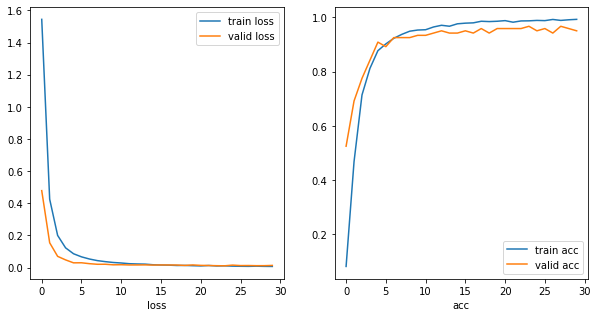

In [17]:
# 用作调参使用
train(model, train_data, valid_data, max_epoch, criterion, optimizer)

通过上面的结果，我们已经将模型跑起来了，那么你的下一个工作就是不断地调参，将验证集的准确率调高，具体的调参方式在课上已经讲过了，比如增加更多的数据增强，或者使用学习率衰减等等，可以通过输出的结果和画出的图像来判断最后模型的好坏

**注意：可能在调参的过程中会出现显存超过限制，这是因为前面一个模型没有释放，所以最好每次调参都重新启动这个 notebook**

当你调完参数之后，得到了一个最优的模型训练方式，那么可以重新训练模型，因为前面我们将数据集拆分成了训练集和验证集两个部分帮助我们调参，现在我们使用完整的数据集重新进行训练以便结果的提交

[934]/[2803], train loss: 0.009, train acc: 0.993
[1868]/[2803], train loss: 0.008, train acc: 0.992
[2802]/[2803], train loss: 0.008, train acc: 0.991
epoch: 1, train loss: 0.008, train acc: 0.991

[934]/[2803], train loss: 0.005, train acc: 0.997
[1868]/[2803], train loss: 0.006, train acc: 0.995
[2802]/[2803], train loss: 0.007, train acc: 0.994
epoch: 2, train loss: 0.007, train acc: 0.994

[934]/[2803], train loss: 0.007, train acc: 0.993
[1868]/[2803], train loss: 0.007, train acc: 0.992
[2802]/[2803], train loss: 0.007, train acc: 0.993
epoch: 3, train loss: 0.007, train acc: 0.993

[934]/[2803], train loss: 0.007, train acc: 0.990
[1868]/[2803], train loss: 0.007, train acc: 0.991
[2802]/[2803], train loss: 0.007, train acc: 0.991
epoch: 4, train loss: 0.007, train acc: 0.991

[934]/[2803], train loss: 0.007, train acc: 0.991
[1868]/[2803], train loss: 0.006, train acc: 0.993
[2802]/[2803], train loss: 0.006, train acc: 0.993
epoch: 5, train loss: 0.006, train acc: 0.993

[934]

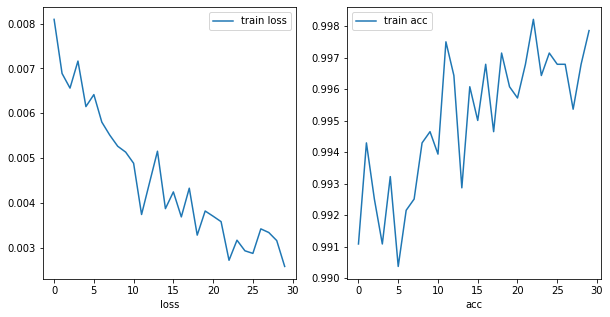

In [18]:
# 完整的训练集
train(model, train_valid_data, None, max_epoch, criterion, optimizer)

当运行完上面的代码之后，可以得到一个训练好的模型，那么我们保存模型

In [19]:
torch.save(model.state_dict(), './save_model.pth')

通过运行下面的程序能够使用你前面训练好的模型，对测试集进行预测，得到结果

In [20]:
# =======不要修改这里的内容========
from utils import TestSet, predict_result

test_set = TestSet('./dataset/test', test_transform)
test_data = DataLoader(test_set, 2*batch_size, num_workers=2)

idx_to_class = dict()
for i in train_set.class_to_idx:
    idx_to_class[train_set.class_to_idx[i]] = i


submission = predict_result(model, test_data, use_gpu)

submission.columns = [['img'] + [i for i in idx_to_class.values()]]

submission.to_csv('./submission.csv', index=False)

/home/zzwang/Desktop/深度学习理论与实战PyTorch实现/05.卷积神经网络（进阶）/资料/27.PyTorch-distracted-driver-P2-master/PyTorch-distracted-driver-P2-master/utils/get_submission_result.py:20: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = Variable(img, volatile=True)


通过运行上面的程序，我们能够在根目录下得到一个提交的csv文件，叫做`submission.csv`，最后只需要将这个文件提交到[kaggle的比赛界面](https://www.kaggle.com/c/state-farm-distracted-driver-detection/leaderboard)即可获得比赛的成绩。